## **Initialization**

In [13]:
import warnings, numpy, matplotlib.pyplot as plot

from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap, MDS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pathlib import Path
from PIL import Image

warnings.filterwarnings('ignore')

SIZE = (512, 512)
PATH = Path('image_files/v0')  
LABELS = ['realistic', 'features', 'blurred', 'geons', 'silhouettes']

In [17]:
data = {}
for label in LABELS:
    features = []
    for file in sorted((PATH/label).iterdir()):
        image = Image.open(file).convert('L').resize(SIZE, Image.Resampling.LANCZOS)
        features.append(numpy.array(image, dtype=numpy.float32).flatten())
    features = numpy.array(features)
    scaler = StandardScaler()
    data[label] = {'features': scaler.fit_transform(features), 'scaler': scaler}

- `.convert('L')` converts the image to grayscale; The 'L' stands for Luminance channel or 8-bit grayscale. 'L' mode images have one channel per pixel (unlike 'RGB' which has three: red, green, blue).
- **Keeping the scaler:** To visually reconstruct images that can be compared with the originals, we must reverse this standardization using the same scaler.
> **Resampling**
>
> Resampling is the process of changing the dimensions of an image by adding or removing pixels when resizing it to a standardized size. LANCZOS method is a high-quality interpolation algorithm that calculates new pixel values when the image size changes.​ LANCZOS resampling uses a mathematical technique that looks at multiple surrounding pixels and computes a weighted average to determine each new pixel's value. This preserves image quality better than simpler methods like nearest neighbor, which just copies the closest pixel value.​

## **Dimensionality Reduction**

In [43]:
results = {}
for label in LABELS:    
    X = data[label]['features']    
    pca = PCA(n_components=min(X.shape))
    results[label] = {
        'pca': pca,
        'X_pca': pca.fit_transform(X),
        'scaler': data[label]['scaler'],
        'explained_variance': pca.explained_variance_ratio_,
        'cumulative_variance': numpy.cumsum(pca.explained_variance_ratio_)
    }
for label in LABELS:
    cumulative_variance = results[label]['cumulative_variance']
    minimum_components = numpy.argmax(cumulative_variance >= 0.95) + 1 if numpy.any(cumulative_variance >= 0.95) else len(cumulative_variance)
    preserved_variance = cumulative_variance[minimum_components - 1]
    print(f'Label: {label}\nMinimum Number of Components: {minimum_components}\nPreserved Variance: {preserved_variance:.4f}')
    if label != LABELS[-1]:  
            print()

Label: realistic
Minimum Number of Components: 30
Preserved Variance: 0.9524

Label: features
Minimum Number of Components: 33
Preserved Variance: 0.9562

Label: blurred
Minimum Number of Components: 23
Preserved Variance: 0.9525

Label: geons
Minimum Number of Components: 39
Preserved Variance: 0.9507

Label: silhouettes
Minimum Number of Components: 31
Preserved Variance: 0.9549


- `X.shape = (sample_count, feature_count)`; If we only have `n` data points (samples). We cannot find more than `n` independent patterns from them. `PCA(n_components=min(X.shape))` is a safety measure that works for both cases.
- Standardizing the pixel values for each label by centering them around zero and scaling them to unit variance is essential for PCA to work properly. If we standardized all the data together, differences between labels could be lost, and PCA might mix up the underlying patterns you want to analyze in each group.
- `argmax` finds the first index where the specified condition is `True`, but if there are none, it returns 0 by default, making `n_comp_95 = 1`, which is misleading.
- PCA is applied to find the principal components — new axes that capture the most variation in the data. The `n_components=min(X.shape)` ensures PCA computes as many components as possible given the data dimensions.
- The `explained_variance_ratio_` shows what percentage of total variance each principal component captures. The `cumulative_variance` sums these ratios to show how much total variance is explained by the first `n` components.
- `n_comp_95 = numpy.argmax(cumsum >= 0.95) + 1` finds the minimum number of components needed to explain at least 95% of the variance in the data. For example, if the original data has 262,144 dimensions (512×512 pixels), we might only need 50 components to capture 95% of the information — a massive dimensionality reduction.

### Original vs PCA-Reconstructed Realistic Images (95% Variance Retained)

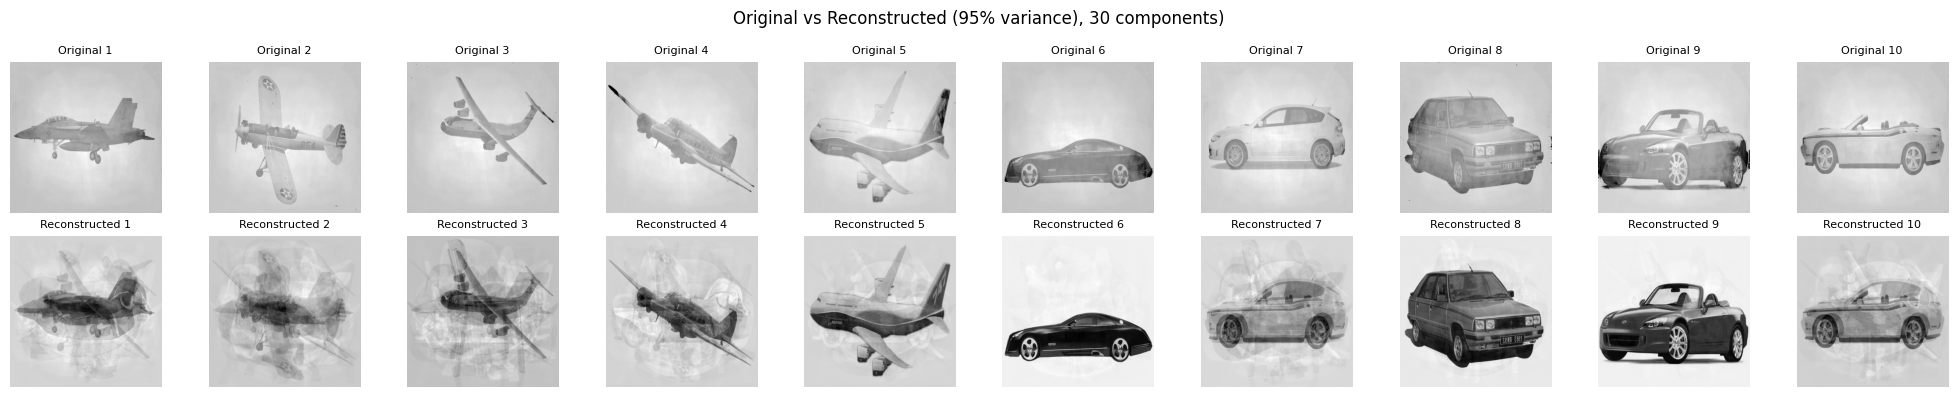

In [ ]:
X_realistic = data['realistic']['features']
scaler_realistic = results['realistic']['scaler']
pca_realistic = results['realistic']['pca']
cumulative_variance = results['realistic']['cumulative_variance']

minimum_components = numpy.argmax(cumulative_variance >= 0.95) + 1 if numpy.any(cumulative_variance >= 0.95) else len(cumulative_variance)

X_projection = pca_realistic.transform(X_realistic)[:, :minimum_components]
X_projection_padded = numpy.column_stack([X_projection, numpy.zeros((X_projection.shape[0], pca_realistic.n_components_ - minimum_components))])

X_reconstructed = pca_realistic.inverse_transform(X_projection_padded)
X_reconstructed = scaler_realistic.inverse_transform(X_reconstructed)

figures, axes = plot.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    original = X_realistic[i].reshape(SIZE)
    reconstructed = X_reconstructed[i].reshape(SIZE)
    axes[0, i].imshow(original, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {i+1}', fontsize=8)
    axes[1, i].imshow(reconstructed, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Reconstructed {i+1}', fontsize=8)

plot.suptitle(f'Original vs Reconstructed (95% variance), {minimum_components} components)', fontsize=12)
plot.tight_layout()
plot.show()

###  Explained Variance by 2 Components

In [45]:
for label in LABELS:
    pca_model = PCA(n_components=2).fit(data[label]['features'])
    explained_variance = numpy.sum(pca_model.explained_variance_ratio_)
    print(f"Label: {label}\nVariance: {explained_variance:.4f}")
    
    if label != LABELS[-1]:
        print()

Label: realistic
Variance: 0.2055

Label: features
Variance: 0.1552

Label: blurred
Variance: 0.3251

Label: geons
Variance: 0.3047

Label: silhouettes
Variance: 0.2910
